# HYPER3D: Hyperspectral data processing

## Loading the library

In [1]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Download data from Zenodo

`pixels_corrected_spectra`shape: (1278720, 698): data matrix of the corrected spectra per pixel for each ROI

`wavelenghts`shape: (698): vector of the wavelenghts of the spectra

`pixels_metadata`, (shape: 1278720, 5): dataframe of the factors related to each pixels (roi_name, roi_filename, roi_transect, roi_project, roi_dive) 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7054416.svg)](https://doi.org/10.5281/zenodo.7054416)

## Load the data

If you data are stored in another directory than the current script change `./` by your file path.

In [2]:
pixels_corrected_spectra = np.load('./pixels_corrected_spectra.npy')
wavelenghts = np.load('./wavelenghts.npy')
pixels_metadata = pd.read_csv('./pixels_metadata.csv',sep=',')

Verify the shape of the data

In [3]:
print(pixels_corrected_spectra.shape)
print(wavelenghts.shape)
print(pixels_metadata.shape)

(1278720, 698)
(698,)
(1278720, 5)


## 1. Second derivative computation over pixels

Computation of second derivative is done on the data of the corrected spectra of each pixels

To keep the overall shape of the spectra curve but erase imperfections that can blur second derivative computation, we smooth the spectra of each pixel using the Savitzky-Golay algorithm (smoothing parameter: `31` points selected and a degree `2` polynomial) . 

The second derivative obtained is then smoothed again 5 time (`for iter_idx in range(5):`) with the same alorithm but with smaller smoothing parameters (`15`) to not smear out smaller peaks too much.

For both computation `delta` is define by the mean difference of the wavelenghts whose graduation is not linear

In [4]:
pixels_second_derivative_spectra = savgol_filter(pixels_corrected_spectra, 
                                                 31, 2, deriv=2, 
                                                 delta=np.diff(wavelenghts).mean(), 
                                                 axis=-1)
for iter_idx in range(5):
    pixels_smoothed_second_derivative_spectra = savgol_filter(pixels_second_derivative_spectra, 
                                                              15, 2, deriv=0, 
                                                              delta=np.diff(wavelenghts).mean(), 
                                                              axis=-1)


Plot of the corrected spectra, second derivative and smoothed second derivative for one pixel

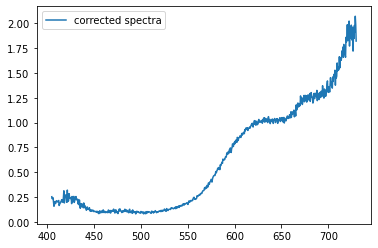

In [5]:
plt.plot(wavelenghts,pixels_corrected_spectra[1,:],label='corrected spectra')
plt.legend()

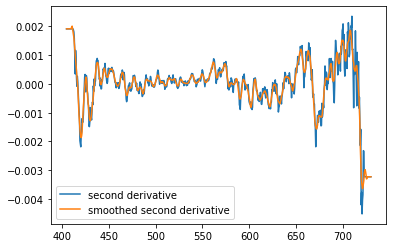

In [6]:
plt.plot(wavelenghts,pixels_second_derivative_spectra[1,:],label='second derivative')
plt.plot(wavelenghts,pixels_smoothed_second_derivative_spectra[1,:],label='smoothed second derivative')
plt.legend()

## 2. Selection of the wavelenghts

We need to visualise the second derivative shape over ROIs and verify the presence of positive peaks that correspond to the photosynthetic pigments we are looking for (Fucoxanthin: 546, phycoerythrin: 567, phycocyanin: 620, chlorophyll c: 635, chlorophyll b: 648, chlorophyll a: 666)

* (1) Round the array wavelenghts to the third decimal to simplify the names of the columns and turn it into list of string

In [7]:
wavelenghts = np.round(wavelenghts,3) 
wavelenghts_str = np.array(wavelenghts).astype('str').tolist() #

* (2) create a panda dataframe of `pixels_smoothed_second_derivative_spectra` with the wavelenghts in columns and concatenate `pixels_smoothed_second_derivative_spectra` and `pixels_metadata`

In [8]:
pixels_smoothed_second_derivative_spectra_pd = pd.DataFrame(pixels_smoothed_second_derivative_spectra,
                                                            columns=wavelenghts_str)
pixels_smoothed_second_derivative_spectra_metadata = pd.concat([pixels_metadata,
                                                                pixels_smoothed_second_derivative_spectra_pd],axis=1)

* (3) Compute the mean over ROI with the function groupby

In [9]:
ROI_mean_smoothed_second_derivative_spectra = pixels_smoothed_second_derivative_spectra_metadata.groupby(
    ['roi_filename','roi_transect','roi_project']).mean()
ROI_mean_smoothed_second_derivative_spectra = ROI_mean_smoothed_second_derivative_spectra.iloc[:,1:]

* (4) plot the second derivative and the verify the peaks corresponding to the photosynthetic pigments. 

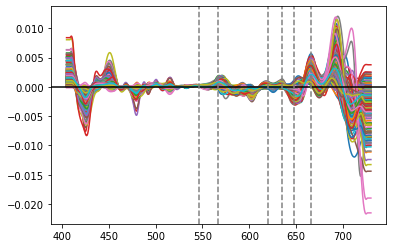

In [10]:

ROI_mean_smoothed_second_derivative_spectra = ROI_mean_smoothed_second_derivative_spectra.select_dtypes(include=[np.number])
ROI_mean_smoothed_second_derivative_spectratoplot = ROI_mean_smoothed_second_derivative_spectra.transpose()
plt.plot(wavelenghts,ROI_mean_smoothed_second_derivative_spectratoplot)
plt.axhline(y=0,color='black')
plt.axvline(x=546,color='gray',linestyle='--')
plt.axvline(x=567,color='gray',linestyle='--')
plt.axvline(x=620,color='gray',linestyle='--')
plt.axvline(x=635,color='gray',linestyle='--')
plt.axvline(x=648,color='gray',linestyle='--')
plt.axvline(x=666,color='gray',linestyle='--')

* (5) identify the wavelenghts in the array. 

In [11]:
wavelenghts 

array([405.014, 405.474, 405.934, 406.394, 406.853, 407.313, 407.773,
       408.233, 408.693, 409.154, 409.614, 410.074, 410.534, 410.994,
       411.454, 411.914, 412.374, 412.834, 413.295, 413.755, 414.215,
       414.675, 415.136, 415.596, 416.056, 416.516, 416.977, 417.437,
       417.898, 418.358, 418.818, 419.279, 419.739, 420.2  , 420.66 ,
       421.121, 421.581, 422.042, 422.502, 422.963, 423.423, 423.884,
       424.344, 424.805, 425.266, 425.726, 426.187, 426.648, 427.108,
       427.569, 428.03 , 428.491, 428.951, 429.412, 429.873, 430.334,
       430.795, 431.255, 431.716, 432.177, 432.638, 433.099, 433.56 ,
       434.021, 434.482, 434.943, 435.404, 435.865, 436.326, 436.787,
       437.248, 437.709, 438.17 , 438.631, 439.093, 439.554, 440.015,
       440.476, 440.937, 441.399, 441.86 , 442.321, 442.782, 443.244,
       443.705, 444.166, 444.628, 445.089, 445.55 , 446.012, 446.473,
       446.935, 447.396, 447.857, 448.319, 448.78 , 449.242, 449.703,
       450.165, 450.

* (6) Select the wavelenghts columns in the `pixels_smoothed_second_derivative_spectra` dataframe

In [12]:
pixels_smoothed_second_derivative_spectra_selected_wavelenghts = pixels_smoothed_second_derivative_spectra_pd.loc[:,
                                                        ['546.07', '567.015', '620.229', '635.206', '648.325', '666.151']]

* (7) rename the data and verify the shape of the reduced dataframe

In [13]:
pixels_smoothed_second_derivative_spectra_reduced = pixels_smoothed_second_derivative_spectra_selected_wavelenghts
print(pixels_smoothed_second_derivative_spectra_reduced.shape) 

(1278720, 6)


* (8) create an array of the selected wavelenghts.

In [14]:
selected_wavelenghts = pixels_smoothed_second_derivative_spectra_reduced.columns
selected_wavelenghts

Index(['546.07', '567.015', '620.229', '635.206', '648.325', '666.151'], dtype='object')

## 3. Absorbance, Presence/absence computation over pixels

Replace negative second derivative by 0 value, you then obtain the intensity of the absorbance of each wavelenght. From this data replace positive second derivtaive by 1 to obtain presence-absence.

verify the shape of the data

In [15]:
pixels_absorbance = np.where(pixels_smoothed_second_derivative_spectra_reduced.select_dtypes(include=[np.number]) 
                             <0, 0, pixels_smoothed_second_derivative_spectra_reduced.select_dtypes(include=[np.number]))
pixels_presence_absence = np.where(pixels_absorbance>0, 1, pixels_absorbance)
print(pixels_presence_absence.shape)
print(pixels_absorbance.shape)

(1278720, 6)
(1278720, 6)


## 4. Reduction of the data

Standardisation of the sampling effort with randomn selection of ROI 

Sampling effort:
* 3DR, Art_OAR, Art_NR, Nat_NR: 6 transects each
* OAR_Nat: 4 transects

### 4.1. Random selection of ROI

To standardise the sampling effort, we select randomnly 30 ROI per reef type within the transect 

* (1) Create the metadata for the ROI from `pixels_metadata` with the function groupby

In [16]:
ROI_metadata = pixels_metadata.groupby(['roi_filename','roi_transect','roi_project']).count()
ROI_metadata = ROI_metadata.select_dtypes(exclude=[np.number])
ROI_metadata = ROI_metadata.reset_index()

* (2) Extract from metadata the Art_OAR and ramdomly select 8 ROI per transect (= 32 ROI for Art_OAR), and get rid of 2 extra ROI

In [17]:
ROI_Art_OAR = ROI_metadata[ROI_metadata['roi_project']=='Art_OAR'] # (2)
ROI_Art_OAR_random_selection = ROI_Art_OAR.sample(frac=1).groupby(['roi_transect']).head(8) # (3)
ROI_Art_OAR_random_selection = ROI_Art_OAR_random_selection.iloc[1:31,:] # (3)

* (3) Extract the other reef from metadata and randomly select 5 ROI per transect (= 30 ROI for each reef type)

In [18]:
other_reefs = ['Art_NR', 'Art_3DR', 'Nat_NR', 'Nat_OAR'] # (4)
ROI_other_reefs = ROI_metadata[ROI_metadata['roi_project'].isin(other_reefs)] #(4)
ROI_other_reefs_random_selection = ROI_other_reefs.sample(frac=1).groupby(['roi_transect']).head(5) # (5)

* (4) Concatenate the two arrays and sort them according to their name.

In [19]:
ROI_metadata_random_selection = [ROI_Art_OAR_random_selection, ROI_other_reefs_random_selection] # (6)
ROI_metadata_random_selection = pd.concat(ROI_metadata_random_selection) # (6)
ROI_metadata_random_selection = ROI_metadata_random_selection.sort_values('roi_project') # (6)

* (5) Create an array of the roi_filename selected randomly

In [20]:
roi_random_selection = np.array(ROI_metadata_random_selection['roi_filename'])

### 4.2. selection of the ROI in the data

(1) With `selected_wavelenghts` in columns create panda dataframe of:
* `pixels_smoothed_second_derivative_spectra_reduced`
* `pixels_absorbance` 
* `pixels_presence_absence` 

In [21]:
pixels_smoothed_second_derivative_spectra_reduced_pd = pd.DataFrame(pixels_smoothed_second_derivative_spectra_reduced,columns=selected_wavelenghts)
pixels_absorbance_pd = pd.DataFrame(pixels_absorbance,columns=selected_wavelenghts)
pixels_presence_absence_pd = pd.DataFrame(pixels_presence_absence,columns=selected_wavelenghts)

(2) Concatenate `pixels_metadata` and the dataframe

In [22]:
pixels_smoothed_second_derivative_spectra_reduced_metadata = pd.concat([pixels_metadata,pixels_smoothed_second_derivative_spectra_reduced_pd],axis=1)
pixels_absorbance_metadata = pd.concat([pixels_metadata,pixels_absorbance_pd],axis=1)
pixels_presence_absence_metadata = pd.concat([pixels_metadata,pixels_presence_absence_pd],axis=1)

* (3) select the ROI in the data witht the vector `roi_random-selection`

In [23]:
pixels_smoothed_second_derivative_spectra_reduced_random_selection = pixels_smoothed_second_derivative_spectra_reduced_metadata[
    pixels_smoothed_second_derivative_spectra_reduced_metadata['roi_filename'].isin(roi_random_selection)]
pixels_absorbance_random_selection = pixels_absorbance_metadata[
    pixels_absorbance_metadata['roi_filename'].isin(roi_random_selection)]
pixels_presence_absence_random_selection = pixels_presence_absence_metadata[
    pixels_presence_absence_metadata['roi_filename'].isin(roi_random_selection)]

* (4) verify the shape of the data

In [24]:
print(pixels_smoothed_second_derivative_spectra_reduced_random_selection.shape)
print(pixels_absorbance_random_selection.shape)
print(pixels_presence_absence_random_selection.shape)

(799200, 11)
(799200, 11)
(799200, 11)


## 5. Computation over ROI

(1) Use the function groupy on the concatanate dataframes to compute over ROI:  
* the mean of absorbance
* the sum of absorbance 
* the sum of cover  

ROI are defined by the factor `roi_filename` from the metadata  
Keep the factors needed for further analysis `'roi_transect','roi_project'` from the metadata

In [25]:
ROI_mean_absorbance = pixels_absorbance_random_selection.groupby(['roi_filename','roi_transect','roi_project']).mean()
ROI_sum_absorbance = pixels_absorbance_random_selection.groupby(['roi_filename','roi_transect','roi_project']).sum()
ROI_sum_cover = pixels_presence_absence_random_selection.groupby(['roi_filename','roi_transect','roi_project']).sum()

* (2) Compute the mean per pixel over ROI of the absorbance of the selected wavelenghts: defined by the sum of the absorbance over ROI (`ROI_sum_absorbance`) divided by the sum of the cover over ROI (`ROI_sum_cover`).

In [26]:
ROI_pixel_mean_absorbance = ROI_sum_absorbance.divide(ROI_sum_cover, axis='columns', level=None, fill_value=None)

* (4) Verify the shape of the data

In [27]:
print(ROI_mean_absorbance.shape)
print(ROI_sum_absorbance.shape)
print(ROI_sum_cover.shape)
print(ROI_pixel_mean_absorbance.shape)

(150, 7)
(150, 7)
(150, 7)
(150, 7)


# 6. Save the final data

* (1) reset the index of the data

In [28]:
# (1)
ROI_mean_absorbance = ROI_mean_absorbance.reset_index()
ROI_sum_absorbance = ROI_sum_absorbance.reset_index()
ROI_sum_cover = ROI_sum_cover.reset_index()
ROI_pixel_mean_absorbance = ROI_pixel_mean_absorbance.reset_index()

* (2) extract metadata for ROI

In [29]:
# (2)
ROI_metadata_reduced = ROI_mean_absorbance.select_dtypes(exclude=[np.number])

* (3) verify the shape of the data

In [30]:
# (3)
print(ROI_mean_absorbance.shape)
print(ROI_sum_absorbance.shape)
print(ROI_sum_cover.shape)
print(ROI_pixel_mean_absorbance.shape)
print(ROI_metadata_reduced.shape)

(150, 10)
(150, 10)
(150, 10)
(150, 10)
(150, 3)


* (4) extract datamatrix and get rid of unecessary columns

In [31]:
# (4) 
ROI_mean_absorbance = ROI_mean_absorbance.select_dtypes(include=[np.number]).iloc[:,1:]
ROI_sum_absorbance = ROI_sum_absorbance.select_dtypes(include=[np.number]).iloc[:,1:]
ROI_sum_cover = ROI_sum_cover.select_dtypes(include=[np.number]).iloc[:,1:]
ROI_pixel_mean_absorbance = ROI_pixel_mean_absorbance.select_dtypes(include=[np.number]).iloc[:,1:]

* (5) rename the columns

In [32]:
# (5)
ROI_mean_absorbance = ROI_mean_absorbance.rename(columns={"546.07": "Fucoxanthin", "567.015":"phycoerythrin", 
                                                          "620.229":"Phycocyanin", "635.206":"Chlorophyll_c", 
                                                          "648.325":"Chlorophyll_b", "666.151": "Chlorophyll_a"})
ROI_sum_absorbance = ROI_sum_absorbance.rename(columns={"546.07": "Fucoxanthin", "567.015":"phycoerythrin", 
                                                        "620.229":"Phycocyanin", "635.206":"Chlorophyll_c", 
                                                        "648.325":"Chlorophyll_b", "666.151": "Chlorophyll_a"})
ROI_sum_cover = ROI_sum_cover.rename(columns={"546.07": "Fucoxanthin", "567.015":"phycoerythrin", 
                                              "620.229":"Phycocyanin", "635.206":"Chlorophyll_c", 
                                              "648.325":"Chlorophyll_b", "666.151": "Chlorophyll_a"})
ROI_pixel_mean_absorbance = ROI_pixel_mean_absorbance.rename(columns={"546.07": "Fucoxanthin", "567.015":"phycoerythrin", 
                                                                      "620.229":"Phycocyanin", "635.206":"Chlorophyll_c", 
                                                                      "648.325":"Chlorophyll_b", "666.151": "Chlorophyll_a"})

* (6) save the data

In [33]:
ROI_mean_absorbance.to_csv(f'ROI_mean_absorbance.csv', sep=';')
ROI_sum_absorbance.to_csv(f'ROI_sum_absorbance.csv', sep=';')
ROI_sum_cover.to_csv(f'ROI_sum_cover.csv', sep=';')
ROI_pixel_mean_absorbance.to_csv(f'ROI_pixel_mean_absorbance.csv', sep=';')
ROI_metadata_reduced.to_csv(f'ROI_metadata_reduced.csv', sep=';')